In [360]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt 
from pyspark.mllib.stat import Statistics
import seaborn as sns

In [361]:
spark = SparkSession.builder.getOrCreate()

In [362]:
df = spark.read.csv("bestsellers with categories.csv", header=True, inferSchema=True)
df.show(10)

+--------------------+--------------------+-----------+-------+-----+----+-----------+
|                Name|              Author|User Rating|Reviews|Price|Year|      Genre|
+--------------------+--------------------+-----------+-------+-----+----+-----------+
|10-Day Green Smoo...|            JJ Smith|        4.7|  17350|    8|2016|Non Fiction|
|   11/22/63: A Novel|        Stephen King|        4.6|   2052|   22|2011|    Fiction|
|12 Rules for Life...|  Jordan B. Peterson|        4.7|  18979|   15|2018|Non Fiction|
|1984 (Signet Clas...|       George Orwell|        4.7|  21424|    6|2017|    Fiction|
|5,000 Awesome Fac...|National Geograph...|        4.8|   7665|   12|2019|Non Fiction|
|A Dance with Drag...| George R. R. Martin|        4.4|  12643|   11|2011|    Fiction|
|A Game of Thrones...| George R. R. Martin|        4.7|  19735|   30|2014|    Fiction|
|A Gentleman in Mo...|         Amor Towles|        4.7|  19699|   15|2017|    Fiction|
|A Higher Loyalty:...|         James Comey|

In [363]:
rdd = spark.sparkContext.textFile("bestsellers with categories.csv")
rdd.top(10)

['You Are a Badass: How to Stop Doubting Your Greatness and Start Living an Awesome Life,Jen Sincero,4.7,14331,8,2019,Non Fiction',
 'You Are a Badass: How to Stop Doubting Your Greatness and Start Living an Awesome Life,Jen Sincero,4.7,14331,8,2018,Non Fiction',
 'You Are a Badass: How to Stop Doubting Your Greatness and Start Living an Awesome Life,Jen Sincero,4.7,14331,8,2017,Non Fiction',
 'You Are a Badass: How to Stop Doubting Your Greatness and Start Living an Awesome Life,Jen Sincero,4.7,14331,8,2016,Non Fiction',
 'Wrecking Ball (Diary of a Wimpy Kid Book 14),Jeff Kinney,4.9,9413,8,2019,Fiction',
 'Wonder,R. J. Palacio,4.8,21625,9,2017,Fiction',
 'Wonder,R. J. Palacio,4.8,21625,9,2016,Fiction',
 'Wonder,R. J. Palacio,4.8,21625,9,2015,Fiction',
 'Wonder,R. J. Palacio,4.8,21625,9,2014,Fiction',
 'Wonder,R. J. Palacio,4.8,21625,9,2013,Fiction']

In [364]:
header = rdd.first()
rdd1 = rdd.filter(lambda x: x != header).map(lambda x: x.split(","))
rdd1 = rdd1.map(lambda x: [",".join(x[:-6])] + x[-6:])
rdd1.top(1)

[['You Are a Badass: How to Stop Doubting Your Greatness and Start Living an Awesome Life',
  'Jen Sincero',
  '4.7',
  '14331',
  '8',
  '2019',
  'Non Fiction']]

In [365]:
rdd_high_rate = rdd1.filter(lambda x: float(x[2]) > 4.7).map(lambda x: float(x[4])).mean()
rdd_high_rate

10.698324022346373

(array([204., 160.,  54.,  66.,  32.,  14.,   4.,   0.,   8.,   3.,   2.,
          0.,   0.,   2.,   1.]),
 array([3.70000e+01, 5.89060e+03, 1.17442e+04, 1.75978e+04, 2.34514e+04,
        2.93050e+04, 3.51586e+04, 4.10122e+04, 4.68658e+04, 5.27194e+04,
        5.85730e+04, 6.44266e+04, 7.02802e+04, 7.61338e+04, 8.19874e+04,
        8.78410e+04]),
 <BarContainer object of 15 artists>)

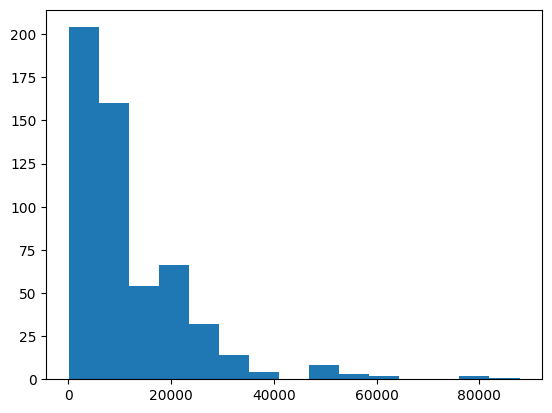

In [366]:
review_data = rdd1.map(lambda x: int(x[3])).collect()
plt.hist(review_data, bins=15)

In [367]:
# df.corr("User Rating", "Reviews")

In [368]:
features =rdd1.map(lambda x: [float(x[2]), int(x[3]), int(x[4])])
corr_mat=Statistics.corr(features, method="pearson")
print(corr_mat)

[[ 1.         -0.00172901 -0.13308629]
 [-0.00172901  1.         -0.10918188]
 [-0.13308629 -0.10918188  1.        ]]


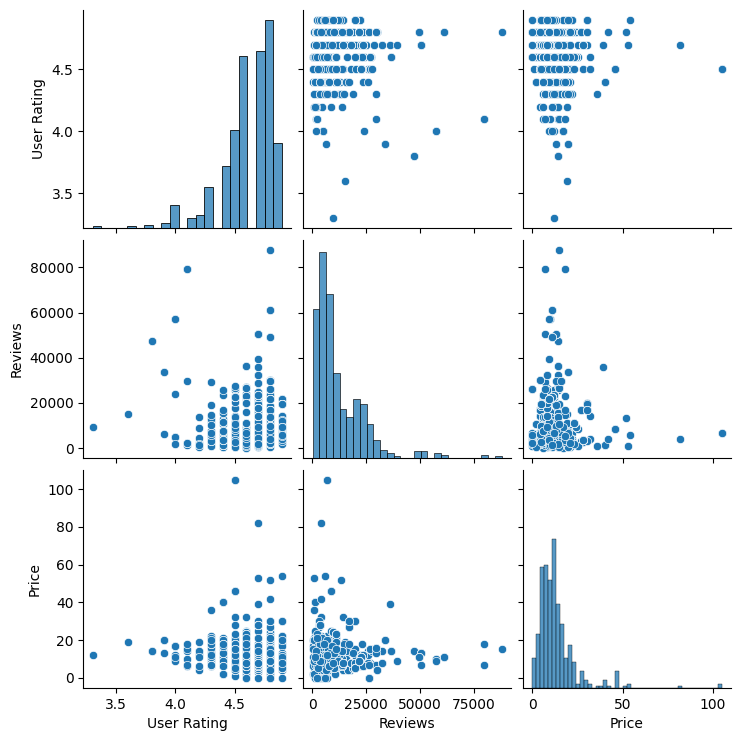

In [369]:
new_df = df["User Rating", "Reviews", "Price"].toPandas()
sns.pairplot(new_df)
plt.show()

# Task2

In [370]:
df1 = df.withColumnRenamed("User Rating", "Rating")
df1.createOrReplaceTempView("books")

In [371]:
max_rate_author = spark.sql("SELECT DISTINCT Author, Rating as max_rating FROM books \
                            WHERE Rating == (SELECT MAX(Rating) FROM books)")\
                            .show(100)

+--------------------+----------+
|              Author|max_rating|
+--------------------+----------+
|Emily Winfield Ma...|       4.9|
|     Bill Martin Jr.|       4.9|
|          Eric Carle|       4.9|
|          Pete Souza|       4.9|
|      Nathan W. Pyle|       4.9|
|         Jeff Kinney|       4.9|
|     Brandon Stanton|       4.9|
|        J.K. Rowling|       4.9|
|         Chip Gaines|       4.9|
|           Dr. Seuss|       4.9|
|      Alice Schertle|       4.9|
|       Rush Limbaugh|       4.9|
|          Dav Pilkey|       4.9|
|       J. K. Rowling|       4.9|
|      Patrick Thorpe|       4.9|
|       Mark R. Levin|       4.9|
|Sherri Duskey Rinker|       4.9|
|          Jill Twiss|       4.9|
|         Sarah Young|       4.9|
|  Lin-Manuel Miranda|       4.9|
+--------------------+----------+



In [372]:
min_rate_author = spark.sql("SELECT DISTINCT Author, Rating as min_rating FROM books \
                            ORDER BY min_rating \
                            LIMIT 3")\
                            .show(100)

+------------+----------+
|      Author|min_rating|
+------------+----------+
|J.K. Rowling|       3.3|
|  Harper Lee|       3.6|
|   E L James|       3.8|
+------------+----------+



In [373]:
max_review_author = spark.sql("SELECT DISTINCT Author, Reviews as max_review FROM books \
                            WHERE Reviews == (SELECT MAX(Reviews) FROM books)")\
                            .show(100)

+-----------+----------+
|     Author|max_review|
+-----------+----------+
|Delia Owens|     87841|
+-----------+----------+



In [374]:
max_review_author = spark.sql("SELECT Author, num FROM (SELECT Author, COUNT(Author) as num FROM books GROUP BY Author) as c\
                              WHERE num == (SELECT COUNT(Author) as num FROM books GROUP BY Author ORDER BY num DESC LIMIT 1)")\
                            .show(100)

+-----------+---+
|     Author|num|
+-----------+---+
|Jeff Kinney| 12|
+-----------+---+



In [375]:
lowest_rate = spark.sql("SELECT Name, Rating, Genre FROM books \
                              WHERE Rating == (SELECT MIN(Rating) as r FROM books \
                                                WHERE Genre == 'Fiction')")\
                            .show(100)

+------------------+------+-------+
|              Name|Rating|  Genre|
+------------------+------+-------+
|The Casual Vacancy|   3.3|Fiction|
+------------------+------+-------+



In [376]:
highest_rate = spark.sql("SELECT DISTINCT Name, Rating, Genre FROM books \
                              WHERE Rating == (SELECT Max(Rating) as r FROM books \
                                                WHERE Genre == 'Non Fiction')\
                                     AND (Genre == 'Non Fiction')")\
                            .show(100)

+--------------------+------+-----------+
|                Name|Rating|      Genre|
+--------------------+------+-----------+
|Hamilton: The Rev...|   4.9|Non Fiction|
|Jesus Calling: En...|   4.9|Non Fiction|
|  The Magnolia Story|   4.9|Non Fiction|
|Obama: An Intimat...|   4.9|Non Fiction|
|Unfreedom of the ...|   4.9|Non Fiction|
|Humans of New Yor...|   4.9|Non Fiction|
+--------------------+------+-----------+



Text(0.5, 1.0, 'Avg Reviews by Year')

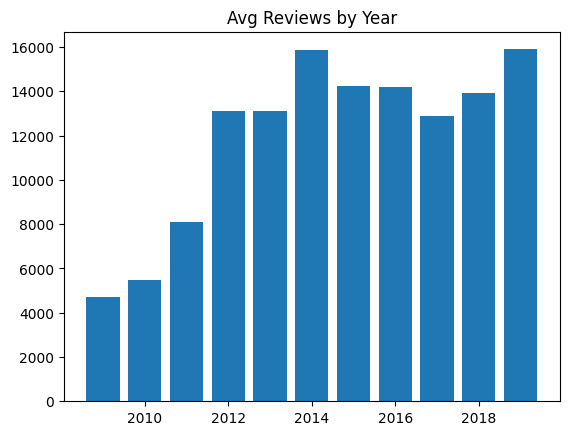

In [377]:
df_year = df.groupBy("Year").avg("Reviews").toPandas()
plt.bar(df_year["Year"], df_year["avg(Reviews)"])
plt.title("Avg Reviews by Year")

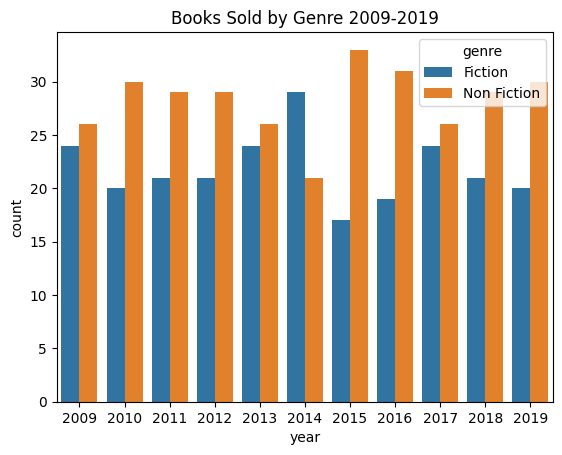

In [386]:
df_genre_count = df.groupby(["year", "genre"]).count().sort("year", "genre").toPandas()
sns.barplot(x="year", y="count", hue="genre", data=df_genre_count)
plt.title("Books Sold by Genre 2009-2019")
plt.show()